
# WEEK 1 TRACK B - Bloch Sphere Trajectories: Pauli Rotations in Practice

In this notebook we are going to take an abstract concept from quantum mechanics—the representation of a single qubit on the Bloch sphere—and make it concrete.  We'll prepare three simple states ($|0
angle$, $|1
angle$ and $|+
angle$), apply the Pauli $X$, $Y$ and $Z$ operations in sequence, and watch how the qubit's Bloch vector moves.  Our goal is to build intuition by connecting algebraic operations to geometric rotations.

Throughout this notebook we follow the structure and style of our previous work: we explain each concept before coding it, we break tasks into small, testable functions, and we check shapes and outputs as we go.  We'll use inclusive language—so when you see “we should pay attention to…”, it means that understanding will pay off later.



## Notebook roadmap

Before we dive into code, here's what we'll cover:

1. **Bloch sphere basics** – how to parameterise a qubit and extract its Bloch vector.
2. **Pauli operators as rotations** – why $X$, $Y$ and $Z$ correspond to half‑turns about the coordinate axes.
3. **Implementation with Qiskit** – importing modules, defining helper functions and plotting trajectories.
4. **Implementation with PennyLane** – repeating the experiment using expectation values rather than statevectors.
5. **Summary and further exploration** – reflecting on what we’ve learned and suggesting next steps.



## 1. Bloch sphere basics

Every pure qubit state can be written in the form
egin{equation}
|\psi
angle = \cos
rac{	heta}{2}\,|0
angle + e^{i\phi}\,\sin
rac{	heta}{2}\,|1
angle,
\end{equation}
where $	heta \in [0,\pi]$ and $\phi \in (-\pi,\pi]$.  Up to a global phase, this pair $(	heta,\phi)$ corresponds to a point on the unit sphere via the **Bloch vector**
egin{equation}

ec r = (\sin	heta\cos\phi,\; \sin	heta\sin\phi,\; \cos	heta).
\end{equation}

We can recover this vector from a density matrix using the Pauli matrices $X,Y,Z$:
egin{equation}

ho = |\psi
angle\langle\psi| = 
rac{1}{2}ig(I + xX + yY + zZig), \quad (x,y,z) = (\langle X
angle,\langle Y
angle,\langle Z
angle).
\end{equation}

Keep in mind that the polar angle in the ket uses **half** the geometric angle ($	heta/2$) because spin‑½ states cover the sphere twice.  We will see this factor of two again when we look at rotations.



## 2. Pauli operators and rotations

The Pauli matrices are defined as
\begin{equation}
X=\begin{pmatrix}0&1\\1&0\end{pmatrix},\quad
Y=\begin{pmatrix}0&-i\\ i&0\end{pmatrix},\quad
Z=\begin{pmatrix}1&0\\0&-1\end{pmatrix}.
\end{equation}

They satisfy $X^2=Y^2=Z^2=I$ and, up to an irrelevant global phase, applying one corresponds to a 180° rotation of the Bloch vector:

- Applying $X$ rotates $\vec r$ by $\pi$ about the $x$-axis: $(x,y,z)\mapsto(x,-y,-z)$.
 half a turn about the $x$‑axis: $(x,y,z)\mapsto(x,-y,-z)$.
- Applying $Y$ rotates about the $y$‑axis: $(x,y,z)\mapsto(-x,y,-z)$.
- Applying $Z$ rotates about the $z$‑axis: $(x,y,z)\mapsto(-x,-y,z)$.

General single‑qubit rotations are implemented by
egin{equation}
R_{\hat n}(	heta) = \exp\Bigl(-\,
rac{i	heta}{2}\,\hat n\cdot
ec\sigma\Bigr),
\end{equation}
which rotates the Bloch vector by $	heta$ about the axis $\hat n$.  A Pauli gate sets $	heta=\pi$.



## 3. Implementation with Qiskit

We will now turn these ideas into code using [Qiskit](https://qiskit.org).  Our plan is to build a single‑qubit circuit, prepare each of the three states, apply $X$, $Y$, $Z$ in sequence and record the Bloch vector after each step.  To make the code easy to follow, we break it into small, self‑contained functions with docstrings explaining inputs and outputs.



### 3.1 Imports and Pauli definitions

First, we import NumPy and Matplotlib for numerical work and plotting, and import the relevant Qiskit classes.  We also define the Pauli matrices as NumPy arrays.  These matrices will be used to compute expectation values and thus the Bloch coordinates.


In [31]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix

# Define Pauli matrices as complex-valued arrays
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

# Inform ourselves of the matrix shapes
print(f"Pauli matrix shapes: X {X.shape}, Y {Y.shape}, Z {Z.shape}")


Pauli matrix shapes: X (2, 2), Y (2, 2), Z (2, 2)



### 3.2 Computing the Bloch vector

To extract the Bloch vector from a `Statevector`, we trace over the Pauli matrices.  The helper function below mirrors the style of our earlier notebooks: it has a clear docstring explaining its parameters and return value, and it returns a three‑component NumPy array.


In [32]:

from qiskit.quantum_info import DensityMatrix

def bloch_vector_from_statevector(sv: Statevector) -> np.ndarray:
    rho = DensityMatrix(sv).data
    x = float(np.real(np.trace(rho @ X)))
    y = float(np.real(np.trace(rho @ Y)))
    z = float(np.real(np.trace(rho @ Z)))
    return np.array([x, y, z], dtype=float)



### 3.3 Plotting the Bloch trajectory

Next we define a plotting function that draws the unit sphere, coordinate axes and connects a list of Bloch vectors.  Like the plotting functions in our earlier notebooks, it includes a docstring and labels the axes.  We'll reuse this function later for both Qiskit and PennyLane trajectories.


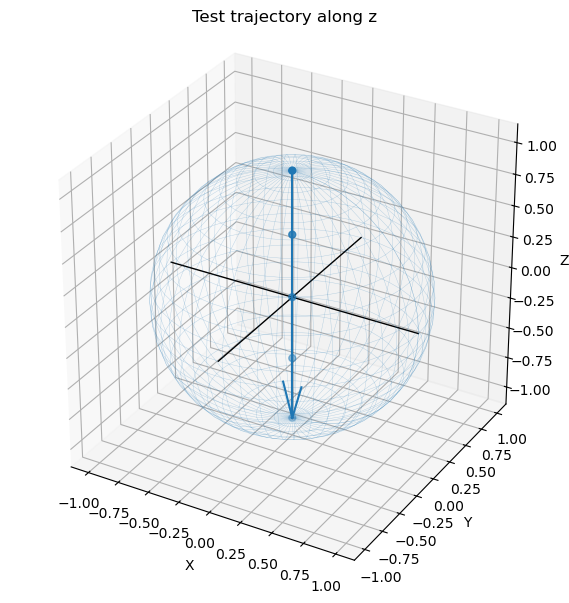

In [33]:

def plot_bloch_trajectory(points: np.ndarray, title: str = "Bloch trajectory") -> None:
    """
    Plot a sequence of Bloch vectors on the unit sphere.

    Parameters
    ----------
    points : array-like of shape (N, 3)
        Sequence of (x, y, z) coordinates defining the trajectory.
    title : str, optional
        Title for the plot, by default "Bloch trajectory".

    Returns
    -------
    None
        Shows a 3D plot of the Bloch sphere and the provided trajectory.
    """
    # Ensure we have a NumPy array
    pts = np.asarray(points, dtype=float)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw the wireframe sphere
    u = np.linspace(0, 2*np.pi, 50)
    v = np.linspace(0, np.pi, 25)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.3)

    # Draw axes
    ax.plot([-1, 1], [0, 0], [0, 0], 'k-', linewidth=1.0)
    ax.plot([0, 0], [-1, 1], [0, 0], 'k-', linewidth=1.0)
    ax.plot([0, 0], [0, 0], [-1, 1], 'k-', linewidth=1.0)

    # Plot the trajectory
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=25)
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linewidth=1.5)
    
    # Draw an arrow to the final point
    ax.quiver(0, 0, 0, pts[-1, 0], pts[-1, 1], pts[-1, 2], length=1.0, normalize=False)

    # Label and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    ax.set_box_aspect((1, 1, 1))
    plt.tight_layout()
    plt.show()

# Test the plotting function with a simple trajectory along the z‑axis
sample_points = np.array([
    [0, 0, 1],
    [0, 0, 0.5],
    [0, 0, 0.0],
    [0, 0, -0.5],
    [0, 0, -1]
])
plot_bloch_trajectory(sample_points, title="Test trajectory along z")



### 3.4 Preparing initial states and evolving under Pauli gates

We now define functions to prepare the three basis states and to apply $X$, $Y$, $Z$ in sequence.  Following our pattern, the `evolution` function returns the statevector after each cumulative gate so that we can compute and plot the Bloch vectors.  Comments inside the code point out why each line exists.


In [34]:

def prep_zero(qc: QuantumCircuit) -> None:
    """
    Prepare the computational basis state |0⟩ on the given circuit.

    Parameters
    ----------
    qc : QuantumCircuit
        A single-qubit quantum circuit.  The qubit is assumed to start in |0⟩.

    Returns
    -------
    None
        The circuit is modified in place; no value is returned.
    """
    # |0⟩ is the default initial state, so there is nothing to do
    return


def prep_one(qc: QuantumCircuit) -> None:
    """
    Prepare the computational basis state |1⟩ on the given circuit.

    Parameters
    ----------
    qc : QuantumCircuit
        A single-qubit quantum circuit.

    Returns
    -------
    None
        The circuit is modified in place; no value is returned.
    """
    qc.x(0)  # flip the qubit from |0⟩ to |1⟩


def prep_plus(qc: QuantumCircuit) -> None:
    """
    Prepare the superposition state |+⟩ = (|0⟩ + |1⟩)/√2 on the given circuit.

    Parameters
    ----------
    qc : QuantumCircuit
        A single-qubit quantum circuit.

    Returns
    -------
    None
        The circuit is modified in place; no value is returned.
    """
    qc.h(0)  # Hadamard creates |+⟩ from |0⟩


def evolution(prep_fn) -> list:
    """
    Create a circuit, prepare a state with `prep_fn`, apply X, Y, Z gates sequentially and
    return the statevectors after each step.

    Parameters
    ----------
    prep_fn : callable
        A function taking a `QuantumCircuit` and preparing one of the basis states.

    Returns
    -------
    list of qiskit.quantum_info.Statevector
        Statevectors representing the state after preparation, after X, after X+Y and after X+Y+Z.
    """
    qc = QuantumCircuit(1)
    prep_fn(qc)
    states = [Statevector.from_instruction(qc)]
    for gate in (qc.x, qc.y, qc.z):
        gate(0)
        states.append(Statevector.from_instruction(qc))
    return states

# Demonstrate the evolution for |+⟩
states_plus = evolution(prep_plus)
print(f"Number of statevectors returned: {len(states_plus)}")
print("Bloch vector after each step:")
for i, sv in enumerate(states_plus):
    vec = bloch_vector_from_statevector(sv)
    print(f"  Step {i}: {vec}")


Number of statevectors returned: 4
Bloch vector after each step:
  Step 0: [1. 0. 0.]
  Step 1: [1. 0. 0.]
  Step 2: [-1.  0.  0.]
  Step 3: [1. 0. 0.]



### 3.5 Running the Qiskit experiments

Now we are ready to put everything together.  We'll loop over our three preparation functions, compute the Bloch vectors after each gate, print out the resulting arrays so we can sanity‑check them, and then call our plotting routine.  When you run this cell, you should see three plots appear.

We encourage you to examine the printed Bloch vectors: do they match the intuitive flips described earlier?  For example, starting from $|+
angle$, the first $X$ should do nothing (because $|+
angle$ is an eigenstate of $X$).



Preparing |0⟩ and applying X, Y, Z...
Bloch vectors:
  Step 0: [0. 0. 1.]
  Step 1: [ 0.  0. -1.]
  Step 2: [0. 0. 1.]
  Step 3: [0. 0. 1.]


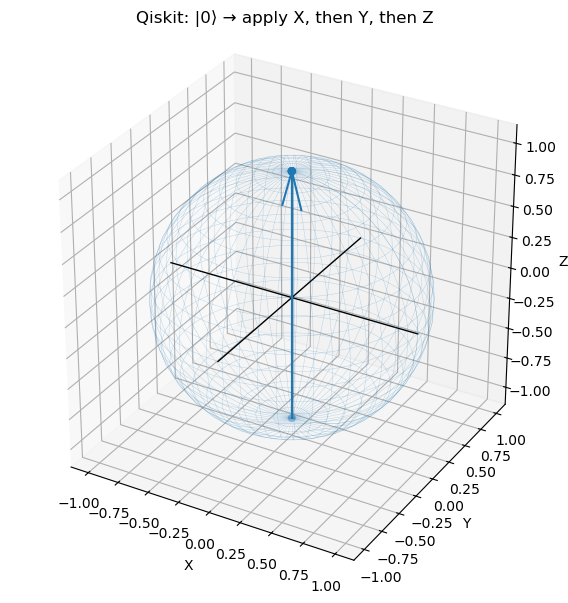


Preparing |1⟩ and applying X, Y, Z...
Bloch vectors:
  Step 0: [ 0.  0. -1.]
  Step 1: [0. 0. 1.]
  Step 2: [ 0.  0. -1.]
  Step 3: [ 0.  0. -1.]


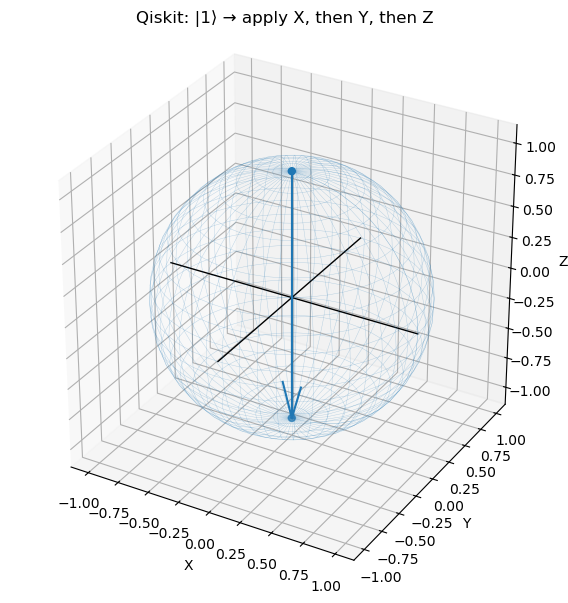


Preparing |+⟩ and applying X, Y, Z...
Bloch vectors:
  Step 0: [1. 0. 0.]
  Step 1: [1. 0. 0.]
  Step 2: [-1.  0.  0.]
  Step 3: [1. 0. 0.]


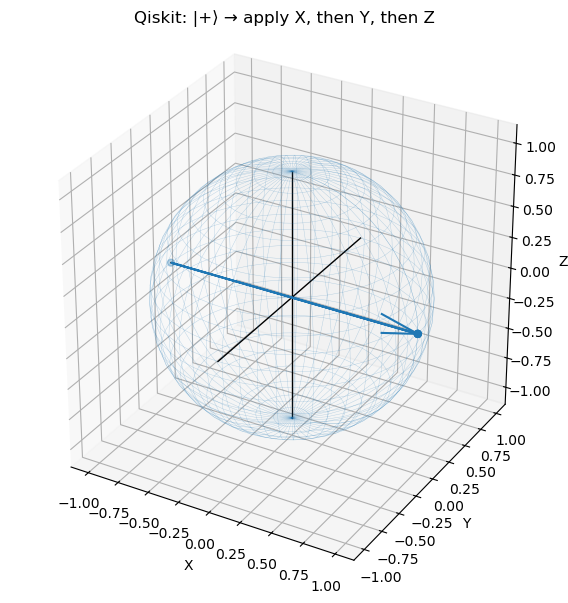

In [35]:

# List of (label, preparation function) pairs
experiments = [
    ("|0⟩", prep_zero),
    ("|1⟩", prep_one),
    ("|+⟩", prep_plus),
]

for label, prep_fn in experiments:
    print(f"\nPreparing {label} and applying X, Y, Z...")
    svs = evolution(prep_fn)

    # Compute the Bloch vectors for all steps
    bloch_points = np.array([bloch_vector_from_statevector(sv) for sv in svs])

    print("Bloch vectors:")
    for i, vec in enumerate(bloch_points):
        print(f"  Step {i}: {vec}")

    # Plot the trajectory on the sphere
    plot_bloch_trajectory(
        bloch_points,
        title=f"Qiskit: {label} → apply X, then Y, then Z"
    )



### 3.6 Interpreting the Qiskit results

The plots above show how our qubit moves on the Bloch sphere.  Starting from $|0
angle$ at the north pole, the $X$ gate sends it to the south pole ($|1
angle$), the $Y$ gate rotates it back to the equator, and $Z$ flips the equatorial components.  Starting from $|+
angle$ (on the equator), $X$ leaves the state unchanged, $Y$ flips it across the $y$‑axis, and $Z$ rotates it in the equator.

We see that the order of operations matters: $X$ then $Y$ does not bring us to the same point as $Y$ then $X$.  This non‑commutativity is a hallmark of rotations in three dimensions and in quantum mechanics alike.



## 4. Implementation with PennyLane

We now repeat the same experiment using PennyLane. Instead of constructing statevectors and taking traces, we will ask the simulator directly for the expectation values of $X$, $Y$ and $Z$.  These expectation values are exactly the Bloch vector components.

As before, we break the code into bite‑sized pieces and provide docstrings and sanity checks along the way.



### 4.1 Imports and device setup

We import NumPy, Matplotlib and PennyLane, and set up a single‑qubit simulator.  We'll reuse our plotting function from the Qiskit section, so we don't need to redefine it.


In [36]:

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

# Create a default.qubit device with one wire
dev = qml.device("default.qubit", wires=1)

print("PennyLane device:", dev)


PennyLane device: <default.qubit device (wires=1) at 0x17f2511d0>



### 4.2 Gate list and preparation functions

Just as in the Qiskit section, we define a list of lambdas that apply the Pauli $X$, $Y$ and $Z$ gates on the first wire.  We also write preparation functions for $|0
angle$, $|1
angle$ and $|+
angle$.  Each function modifies the quantum state inside a `qnode`.


In [37]:
# Define the gates as callables returning operations on wire 0
GATES = [
    lambda: qml.PauliX(0),
    lambda: qml.PauliY(0),
    lambda: qml.PauliZ(0),
]

# Preparation functions
def pl_prep_zero() -> None:
    """Prepare |0⟩ on the PennyLane device. default.qubit starts in |0⟩."""
    return

def pl_prep_one() -> None:
    """Prepare |1⟩ on the PennyLane device by applying an X gate."""
    qml.PauliX(0)

def pl_prep_plus() -> None:
    """Prepare |+⟩ on the PennyLane device by applying a Hadamard."""
    qml.Hadamard(0)

# Helper: build a tiny one-off circuit that prepares a state, then measures ⟨Z⟩
def measure_z_after(prep_fn):
    @qml.qnode(dev)
    def circuit():
        prep_fn()
        return qml.expval(qml.PauliZ(0))
    return circuit()

# Sanity check: verify that the preparations work by measuring ⟨Z⟩
z0   = measure_z_after(pl_prep_zero)  # should be ~ +1
z1   = measure_z_after(pl_prep_one)   # should be ~ -1
zplus= measure_z_after(pl_prep_plus)  # should be ~ 0

print("⟨Z⟩ for |0⟩, |1⟩, |+⟩:", (z0, z1, zplus))



⟨Z⟩ for |0⟩, |1⟩, |+⟩: (np.float64(1.0), np.float64(-1.0), np.float64(0.0))



### 4.3 Expectation function and trajectory construction

The function `bloch_after_k` uses a `qnode` to prepare a state, apply the first $k$ gates from our list and return the expectation values of $X$, $Y$ and $Z$.  Notice that we explicitly specify the observables we want at the end of the circuit.  The outer function `trajectory` wraps this, giving us the Bloch vector after 0, 1, 2 and 3 operations.


In [38]:

def bloch_after_k(prep_fn, k: int) -> np.ndarray:
    """
    Return the Bloch vector after preparing with `prep_fn` and applying the first k gates from [X, Y, Z].

    Parameters
    ----------
    prep_fn : callable
        A preparation function that writes to wire 0 in a PennyLane circuit.
    k : int
        Number of gates to apply (0 through 3).

    Returns
    -------
    np.ndarray of shape (3,)
        The expectation values (⟨X⟩, ⟨Y⟩, ⟨Z⟩) after the operations.
    """
    @qml.qnode(dev)
    def circuit():
        prep_fn()
        # Apply the first k gates in our list
        for g in GATES[:k]:
            g()
        # Return expectation values of X, Y, Z
        return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))
    x, y, z = circuit()
    return np.array([x, y, z], dtype=float)


def pl_trajectory(prep_fn) -> np.ndarray:
    """
    Compute the sequence of Bloch vectors after applying 0, 1, 2 and 3 gates.

    Parameters
    ----------
    prep_fn : callable
        A preparation function for the PennyLane device.

    Returns
    -------
    np.ndarray of shape (4, 3)
        Each row is the Bloch vector after an increasing number of gates.
    """
    return np.array([bloch_after_k(prep_fn, k) for k in range(4)])

# Check the trajectory for |0⟩
traj_zero = pl_trajectory(pl_prep_zero)
print("Trajectory shape:", traj_zero.shape)
print("Bloch vectors for |0⟩:")
for i, vec in enumerate(traj_zero):
    print(f"  Step {i}: {vec}")


Trajectory shape: (4, 3)
Bloch vectors for |0⟩:
  Step 0: [0. 0. 1.]
  Step 1: [ 0.  0. -1.]
  Step 2: [0. 0. 1.]
  Step 3: [0. 0. 1.]



### 4.4 Running the PennyLane experiments

We now loop over the three initial states, compute their trajectories using `pl_trajectory` and reuse our plotting function.  Because each `bloch_after_k` call uses an independent `qnode`, the computations are deterministic and free of sampling noise.



PennyLane: preparing |0⟩ and applying X, Y, Z...
Bloch vectors:
  Step 0: [0. 0. 1.]
  Step 1: [ 0.  0. -1.]
  Step 2: [0. 0. 1.]
  Step 3: [0. 0. 1.]


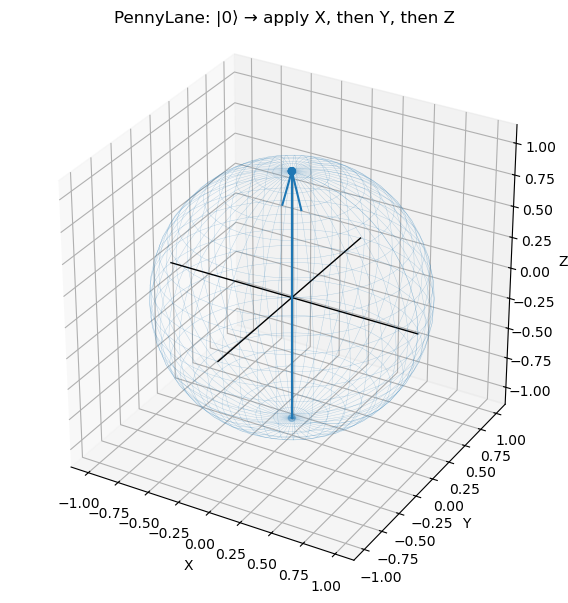


PennyLane: preparing |1⟩ and applying X, Y, Z...
Bloch vectors:
  Step 0: [ 0.  0. -1.]
  Step 1: [0. 0. 1.]
  Step 2: [ 0.  0. -1.]
  Step 3: [ 0.  0. -1.]


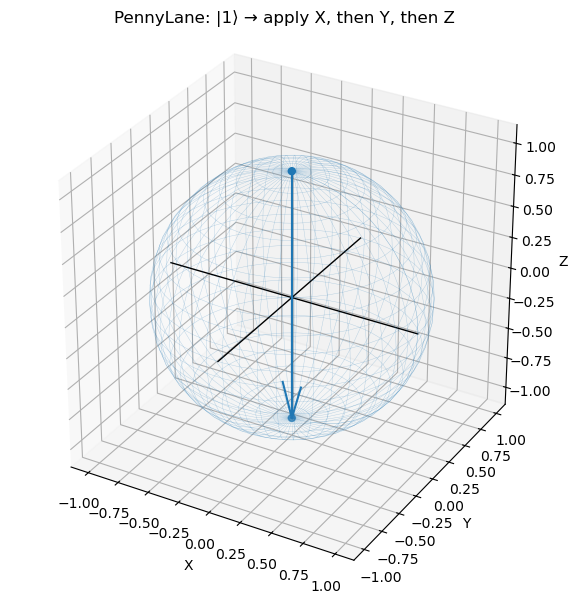


PennyLane: preparing |+⟩ and applying X, Y, Z...
Bloch vectors:
  Step 0: [1. 0. 0.]
  Step 1: [1. 0. 0.]
  Step 2: [-1.  0.  0.]
  Step 3: [1. 0. 0.]


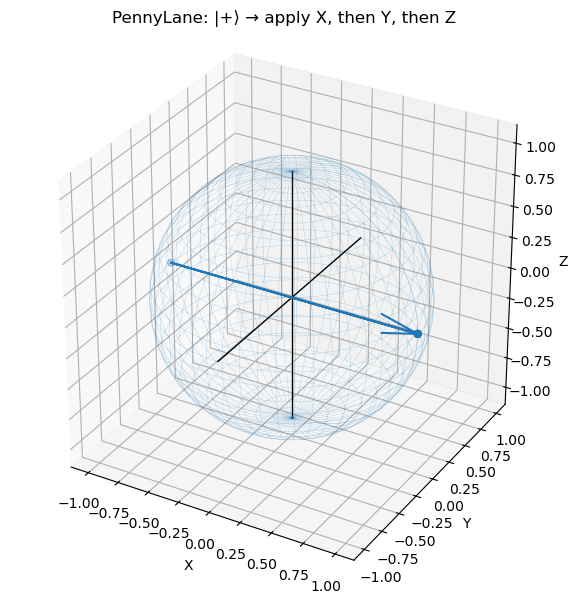

In [39]:

pl_experiments = [
    ("|0⟩", pl_prep_zero),
    ("|1⟩", pl_prep_one),
    ("|+⟩", pl_prep_plus),
]

for label, prep_fn in pl_experiments:
    print(f"\nPennyLane: preparing {label} and applying X, Y, Z...")
    traj = pl_trajectory(prep_fn)

    print("Bloch vectors:")
    for i, vec in enumerate(traj):
        # pretty print to 3 decimals; remove `formatter` if you want full precision
        print(f"  Step {i}: {np.array2string(vec, precision=3, suppress_small=True)}")

    plot_bloch_trajectory(traj, title=f"PennyLane: {label} → apply X, then Y, then Z")



### 4.5 Comparing PennyLane and Qiskit results

The PennyLane trajectories should match what we saw in the Qiskit section.  The difference lies only in the implementation: Qiskit gave us statevectors, while PennyLane gave us expectation values directly.  The physics is the same, and the plots confirm that Pauli gates correspond to half‑turns on the Bloch sphere.



## 5. Summary and further exploration

In this notebook we built a bridge between algebra and geometry.  By parameterising qubit states on the Bloch sphere, understanding how Pauli operators rotate that sphere, and implementing the experiment in two quantum frameworks, we gained a concrete picture of single‑qubit dynamics.

Here are some directions you might explore next:

- **Change the order of gates**: try $Z$–$Y$–$X$ or other permutations and observe how the trajectories differ.
- **Smooth rotations**: replace a single $X$ with multiple small $R_x$ rotations to draw continuous arcs.
- **Noise models**: introduce dephasing or amplitude damping and watch the Bloch vector shrink toward the centre.
